In [1]:
# Initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import os

In [2]:
#Visualization setup
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

#Setup seed for reproducibility
np.random.seed(42)

#Setup pandas to display more columns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)



##LOADING AND CONSOLIDATING DATA

In [3]:
def load_ciciot_dataset(data_path='../../data/raw/CSV/MERGED_CSV', sample_size=None, files_to_load=None):
    """
    Load and conslidate data from CICIOT dataset.
    Args:
        data_path (str): Path to the data directory.
        sample_size (int): Number of sapmles to load.
        files_to_load (list): List of files to load.

    Returns:
        pd.DataFrame: Consolidated dataframe with all the data.
    """
    data_path = Path(data_path)
    datasets = []

    #List available files
    if files_to_load is None:
        csv_files = sorted(data_path.glob('*.csv'))
    else:
        csv_files = [data_path / f for f in files_to_load]

    print(f"Loading {len(csv_files)} files from {data_path}")

    total_rows = 0
    for i, file_path in enumerate(csv_files):
        try:
            print(f"{i+1}/{len(csv_files)}: {file_path.name}")

            #Load in chunks for large files
            chunk_size = 10000
            chunks = []
            for chunk in pd.read_csv(file_path, chunksize=chunk_size):
                if sample_size and total_rows >= sample_size:
                    break
                chunks.append(chunk)
                total_rows += len(chunk)

            if chunks:
                df = pd.concat(chunks, ignore_index=True)
                datasets.append(df)
        
        except Exception as e:
            print(f"Error loading {file_path.name}: {e}")

    #Consolidate all datasets
    if datasets:
        full_dataset = pd.concat(datasets, ignore_index=True)

        #Apply sampling if it is specified
        if sample_size and len(full_dataset) > sample_size:
            full_dataset = full_dataset.sample(n=sample_size, random_state=42)
        print(f"Dataset loaded: {full_dataset.shape}")
        return full_dataset
    else:
        raise ValueError("No data loaded")

In [4]:
df = load_ciciot_dataset(sample_size=2000, files_to_load=['Merged01.csv'])

Loading 1 files from ../../data/raw/CSV/MERGED_CSV
1/1: Merged01.csv
Dataset loaded: (2000, 40)


##VERIFYING DATA

In [5]:
def initial_data_inspection(df):
    """Initial data inspection"""
    print("="*50)
    print("Initial data Inspection)")
    print("="*50)

    #Basic info
    print(f"Dimensions: {df.shape}")
    print(f"Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    # print(f"Período dos dados: {pd.to_datetime(df['ts'], unit='s').min()} a {pd.to_datetime(df['ts'], unit='s').max()}")

    #Data types
    print("\nData types:")
    print(df.dtypes.value_counts())

    ##Missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"\nMissing values: {missing_values.sum()}")
        print(missing_values[missing_values > 0])
    else:
        print("\nNo missing values found")

    #infinite values
    infinite_values = df.isin([np.inf, -np.inf]).sum()
    if infinite_values.sum() > 0:
        print(f"\nInfinite values: {infinite_values.sum()}")
        print(infinite_values[infinite_values > 0])
    else:
        print("\nNo infinite values found")

    #Constant columns
    constant_columns = df.nunique() == 1
    if constant_columns.sum() > 0:
        print(f"\nConstant columns: {constant_columns.sum()}")
        print(constant_columns[constant_columns])
    else:
        print("\nNo constant columns found")

    #Duplicated rows
    duplicated_rows = df.duplicated().sum()
    print(f"\nDuplicated rows: {duplicated_rows} ({(duplicated_rows/df.shape[0])*100:.2f}%)")

    #Columns informations
    print(f"\nColumns ({len(df.columns)}):")
    for col in df.columns:
        print(f" - {col}")
    
    # return df.info()


In [20]:
initial_data_inspection(df)

Initial data Inspection)
Dimensions: (2000, 40)
Memory Usage: 0.63 MB

Data types:
float64    30
int64       9
object      1
Name: count, dtype: int64

No missing values found

No infinite values found

Constant columns: 5
cwr_flag_number    True
Telnet             True
SMTP               True
SSH                True
IRC                True
dtype: bool

Duplicated rows: 2 (0.10%)

Columns (40):
 - Header_Length
 - Protocol Type
 - Time_To_Live
 - Rate
 - fin_flag_number
 - syn_flag_number
 - rst_flag_number
 - psh_flag_number
 - ack_flag_number
 - ece_flag_number
 - cwr_flag_number
 - ack_count
 - syn_count
 - fin_count
 - rst_count
 - HTTP
 - HTTPS
 - DNS
 - Telnet
 - SMTP
 - SSH
 - IRC
 - TCP
 - UDP
 - DHCP
 - ARP
 - ICMP
 - IGMP
 - IPv
 - LLC
 - Tot sum
 - Min
 - Max
 - AVG
 - Std
 - Tot size
 - IAT
 - Number
 - Variance
 - Label


##Univariate Descriptive Analysis

In [7]:
def analyze_class_distribution(df, label_col='Label'):
    """Detailed analysis of class distribution"""
    print("="*50)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("="*50)

    #Class count
    class_counts = df[label_col].value_counts()
    class_percentages = df[label_col].value_counts(normalize=True) * 100

    #Create dataframe for visualization
    class_summary = pd.DataFrame({
        'Count': class_counts,
        'Percentage': class_percentages
    }).sort_values('Count', ascending=False)

    #Display summary
    print("\nClass Distribution Summary:")
    print(class_summary)

    #Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    #Bar chart
    class_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Class Distribution')
    axes[0,0].set_xlabel('Class')
    axes[0,0].set_ylabel('Count')
    # axes[0,0].tick_params(axis='x', rotation=45)

    #Pie chart - group non-representative categories as 'others'
    # Define threshold for grouping (e.g., less than 5% becomes 'Others')
    threshold = 0.01
    class_percentages_grouped = class_percentages.copy()
    
    # Identify categories below threshold
    small_categories = class_percentages_grouped[class_percentages_grouped < threshold * 100]
    
    if len(small_categories) > 1:
        # Sum small categories
        others_sum = small_categories.sum()
        # Remove small categories
        class_percentages_grouped = class_percentages_grouped[class_percentages_grouped >= threshold * 100]
        # Add 'Others' category
        class_percentages_grouped['Others'] = others_sum
    
    # Convert back to counts for pie chart
    total_samples = len(df)
    class_counts_grouped = (class_percentages_grouped / 100 * total_samples).round().astype(int)
        
    class_counts_grouped.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
    axes[0,1].set_title('Class Distribution (%) - Grouped')
    axes[0,1].set_ylabel('')

    # Log Bar chart
    class_counts.plot(kind='bar', ax=axes[1,0], color='lightcoral', logy=True)
    axes[1,0].set_title('Class Distribution Logarithmic Scale')
    axes[1,0].set_xlabel('Class')
    axes[1,0].set_ylabel('Count')
    # axes[0,0].tick_params(axis='x', rotation=45)

    # Horizontal bar chart
    class_counts.plot(kind='barh', ax=axes[1,1], color='lightgreen')
    axes[1,1].set_title('Class Distribution - Horizontal')
    axes[1,1].set_xlabel('Count')


    plt.tight_layout()
    plt.show()

    return class_summary

CLASS DISTRIBUTION ANALYSIS

Class Distribution Summary:
                         Count  Percentage
Label                                     
DDOS-ICMP_FLOOD            309       15.45
DDOS-UDP_FLOOD             211       10.55
DDOS-TCP_FLOOD             201       10.05
DDOS-PSHACK_FLOOD          173        8.65
DDOS-RSTFINFLOOD           172        8.60
DDOS-SYNONYMOUSIP_FLOOD    151        7.55
DDOS-SYN_FLOOD             142        7.10
DOS-UDP_FLOOD              131        6.55
DOS-TCP_FLOOD              126        6.30
DOS-SYN_FLOOD              108        5.40
BENIGN                      68        3.40
MIRAI-UDPPLAIN              39        1.95
MIRAI-GREETH_FLOOD          38        1.90
MIRAI-GREIP_FLOOD           31        1.55
MITM-ARPSPOOFING            17        0.85
DDOS-ICMP_FRAGMENTATION     16        0.80
VULNERABILITYSCAN           15        0.75
DDOS-UDP_FRAGMENTATION      12        0.60
DNS_SPOOFING                11        0.55
DDOS-ACK_FRAGMENTATION      11        0.

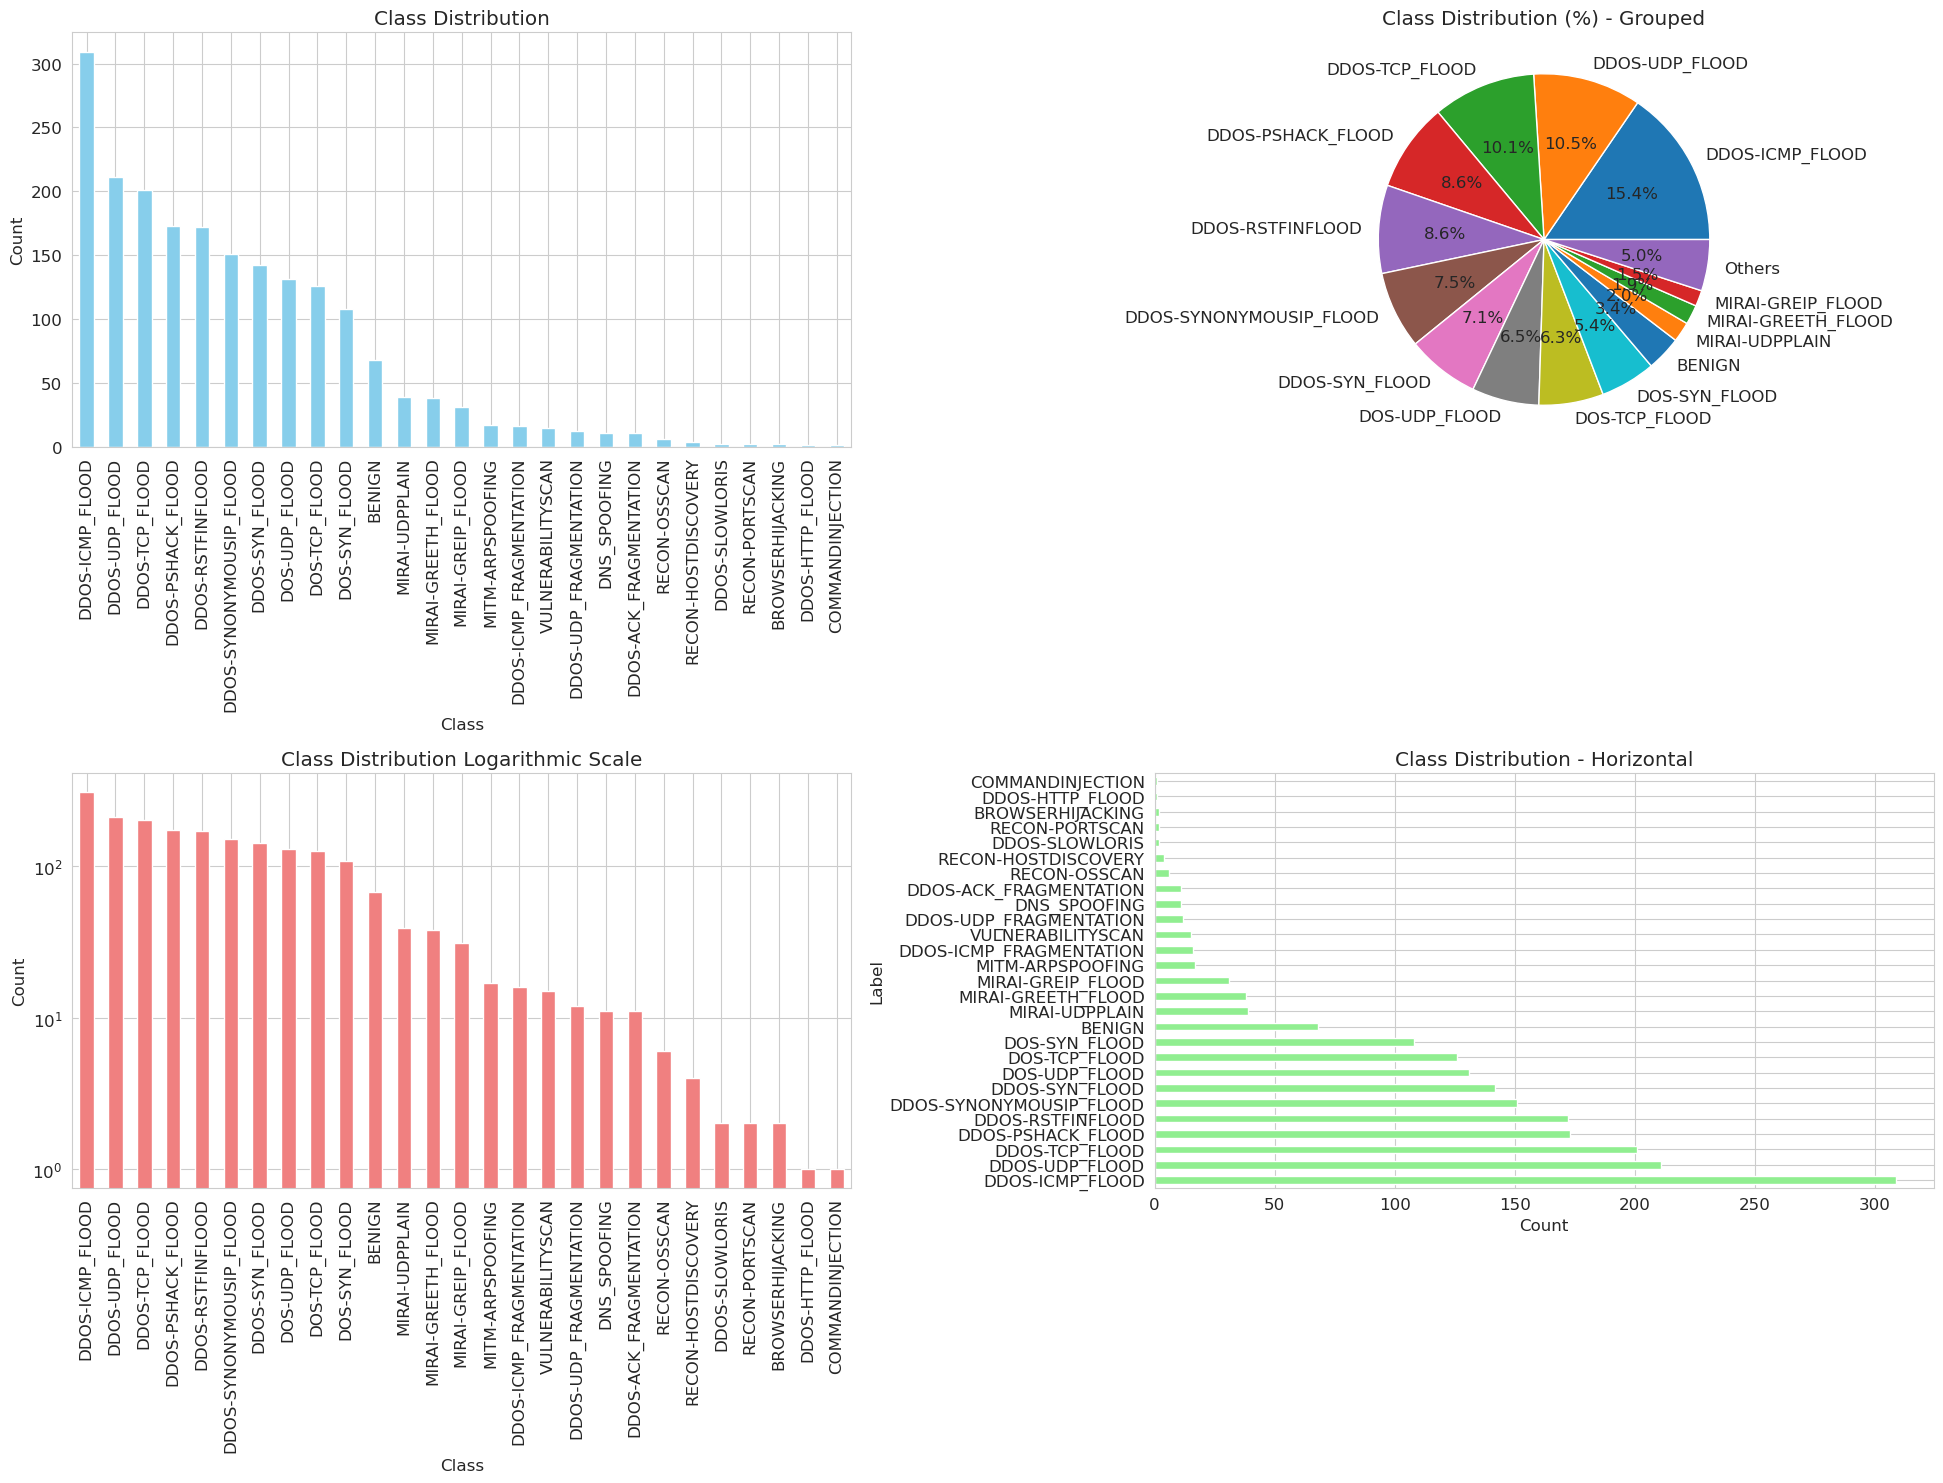

,Count,Percentage
Label,,
DDOS-ICMP_FLOOD,309,15.45
DDOS-UDP_FLOOD,211,10.55
DDOS-TCP_FLOOD,201,10.05
DDOS-PSHACK_FLOOD,173,8.65
DDOS-RSTFINFLOOD,172,8.60
DDOS-SYNONYMOUSIP_FLOOD,151,7.55
DDOS-SYN_FLOOD,142,7.10
DOS-UDP_FLOOD,131,6.55
DOS-TCP_FLOOD,126,6.30


In [8]:
analyze_class_distribution(df)

In [9]:
def balance_analysis(df, label_col='Label'):
    """Detailed analysis of class distribution"""
    print("="*50)
    print("BALANCE ANALYSIS")
    print("="*50)

    class_counts = df[label_col].value_counts()

    total_samples = len(df)
    majority_class = class_counts.index[0]
    minority_class = class_counts.index[-1]

    inbalance_ratio = class_counts.max() / class_counts.min()

    print(f"Balance Analysis:")
    print(f"Total samples: {total_samples}")
    print(f"Majority class: {majority_class} ({class_counts.max()} samples)")
    print(f"Minority class: {minority_class} ({class_counts.min()} samples)")
    print(f"Inbalance ratio: {inbalance_ratio:.2f}")

    return total_samples, majority_class, minority_class, inbalance_ratio   

In [10]:
total_samples, majority_class, minority_class, inbalance_ratio = balance_analysis(df)

BALANCE ANALYSIS
Balance Analysis:
Total samples: 2000
Majority class: DDOS-ICMP_FLOOD (309 samples)
Minority class: COMMANDINJECTION (1 samples)
Inbalance ratio: 309.00


### Desctiptive Statistical Analysis

In [11]:
def comphehensive_statistical_analysis(df):
    """
    Descriptive statistical analysis of the numerical columns of the dataset.
    """

    print("="*50)
    print("Descriptive statistical analysis of the numerical columns of the dataset.")
    print("="*50)

    #Separate numerical and categorical columns
    numeric_features = df.select_dtypes(include=['number']).columns.tolist()

    if 'ts' in numeric_features:
        numeric_features.remove('ts')

    
    print(f"Analyzing {len(numeric_features)} numerical columns...")

    #Basic statistics
    desc_stats = df[numeric_features].describe()
    print(desc_stats)

    #Aditional statistics
    additional_stats = pd.DataFrame({
        'Skewness': df[numeric_features].skew(),
        'Kurtosis': df[numeric_features].kurtosis(),
        'cv': df[numeric_features].std() / df[numeric_features].mean(),
        'IQR': df[numeric_features].quantile(0.75) - df[numeric_features].quantile(0.25),
        'Range': df[numeric_features].max() - df[numeric_features].min(),
        'Min': df[numeric_features].min(),
        'Max': df[numeric_features].max(),
    })

    #Combine statistics
    full_stats = pd.concat([desc_stats.T, additional_stats], axis=1)

    #Save statistics to csv
    full_stats.to_csv('results/tables/descriptive_analysis.csv')

    #Identify special behaviored features
    print("\nHigh variability features: (CV > 1)")
    high_cv = additional_stats[additional_stats['cv'] > 1].sort_values('cv', ascending=False)
    print(high_cv)

    print("\n High skewness features: (|Skewness|> 2)")
    high_skew = additional_stats[abs(additional_stats['Skewness']) > 2].sort_values('Skewness', ascending=False)
    print(high_skew)

    #Save statistics to csv
    # high_cv.to_csv('src/eda/results/tables/high_cv.csv', index=True)
    # high_skew.to_csv('src/eda/results/tables/high_skew.csv', index=True)

    plot_feature_distribution(df, numeric_features[:16])

    return full_stats

def plot_feature_distribution(df, features):
    """
    Plot the distribution of a feature in the dataset.
    """
    n_features = len(features)
    n_cols = 4
    n_rows = (n_features + n_cols -1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        df[feature].hist(bins=50, ax=axes[i], alpha=0.7, color='skyblue')
        axes[i].set_title(f"{feature}")
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

        #Add mean and median lines
        mean_value = df[feature].mean()
        median_value = df[feature].median()
        axes[i].axvline(mean_value, color='red', linestyle='--', label='Mean')
        axes[i].axvline(median_value, color='green', linestyle='--', label='Median')
        axes[i].legend()

    #Remove extra subplots if any
    for i in range(n_features, len(axes)):
        axes[i].remove()

    plt.tight_layout()
    plt.show()

Descriptive statistical analysis of the numerical columns of the dataset.
Analyzing 39 numerical columns...
       Header_Length  Protocol Type  Time_To_Live           Rate  \
count    2000.000000    2000.000000   2000.000000    2000.000000   
mean       14.089154       8.856500     67.115077   29051.103573   
std         8.893864       8.873966     17.353281   28605.393261   
min         0.000000       0.000000     37.800000      18.615802   
25%         8.000000       6.000000     64.000000   12211.849907   
50%        20.000000       6.000000     64.000000   25144.953711   
75%        20.000000       6.000000     64.000000   38376.020766   
max        54.400000      47.000000    247.000000  358487.521368   

       fin_flag_number  syn_flag_number  rst_flag_number  psh_flag_number  \
count      2000.000000      2000.000000      2000.000000      2000.000000   
mean          0.086725         0.199365         0.092155         0.097070   
std           0.279430         0.394643         

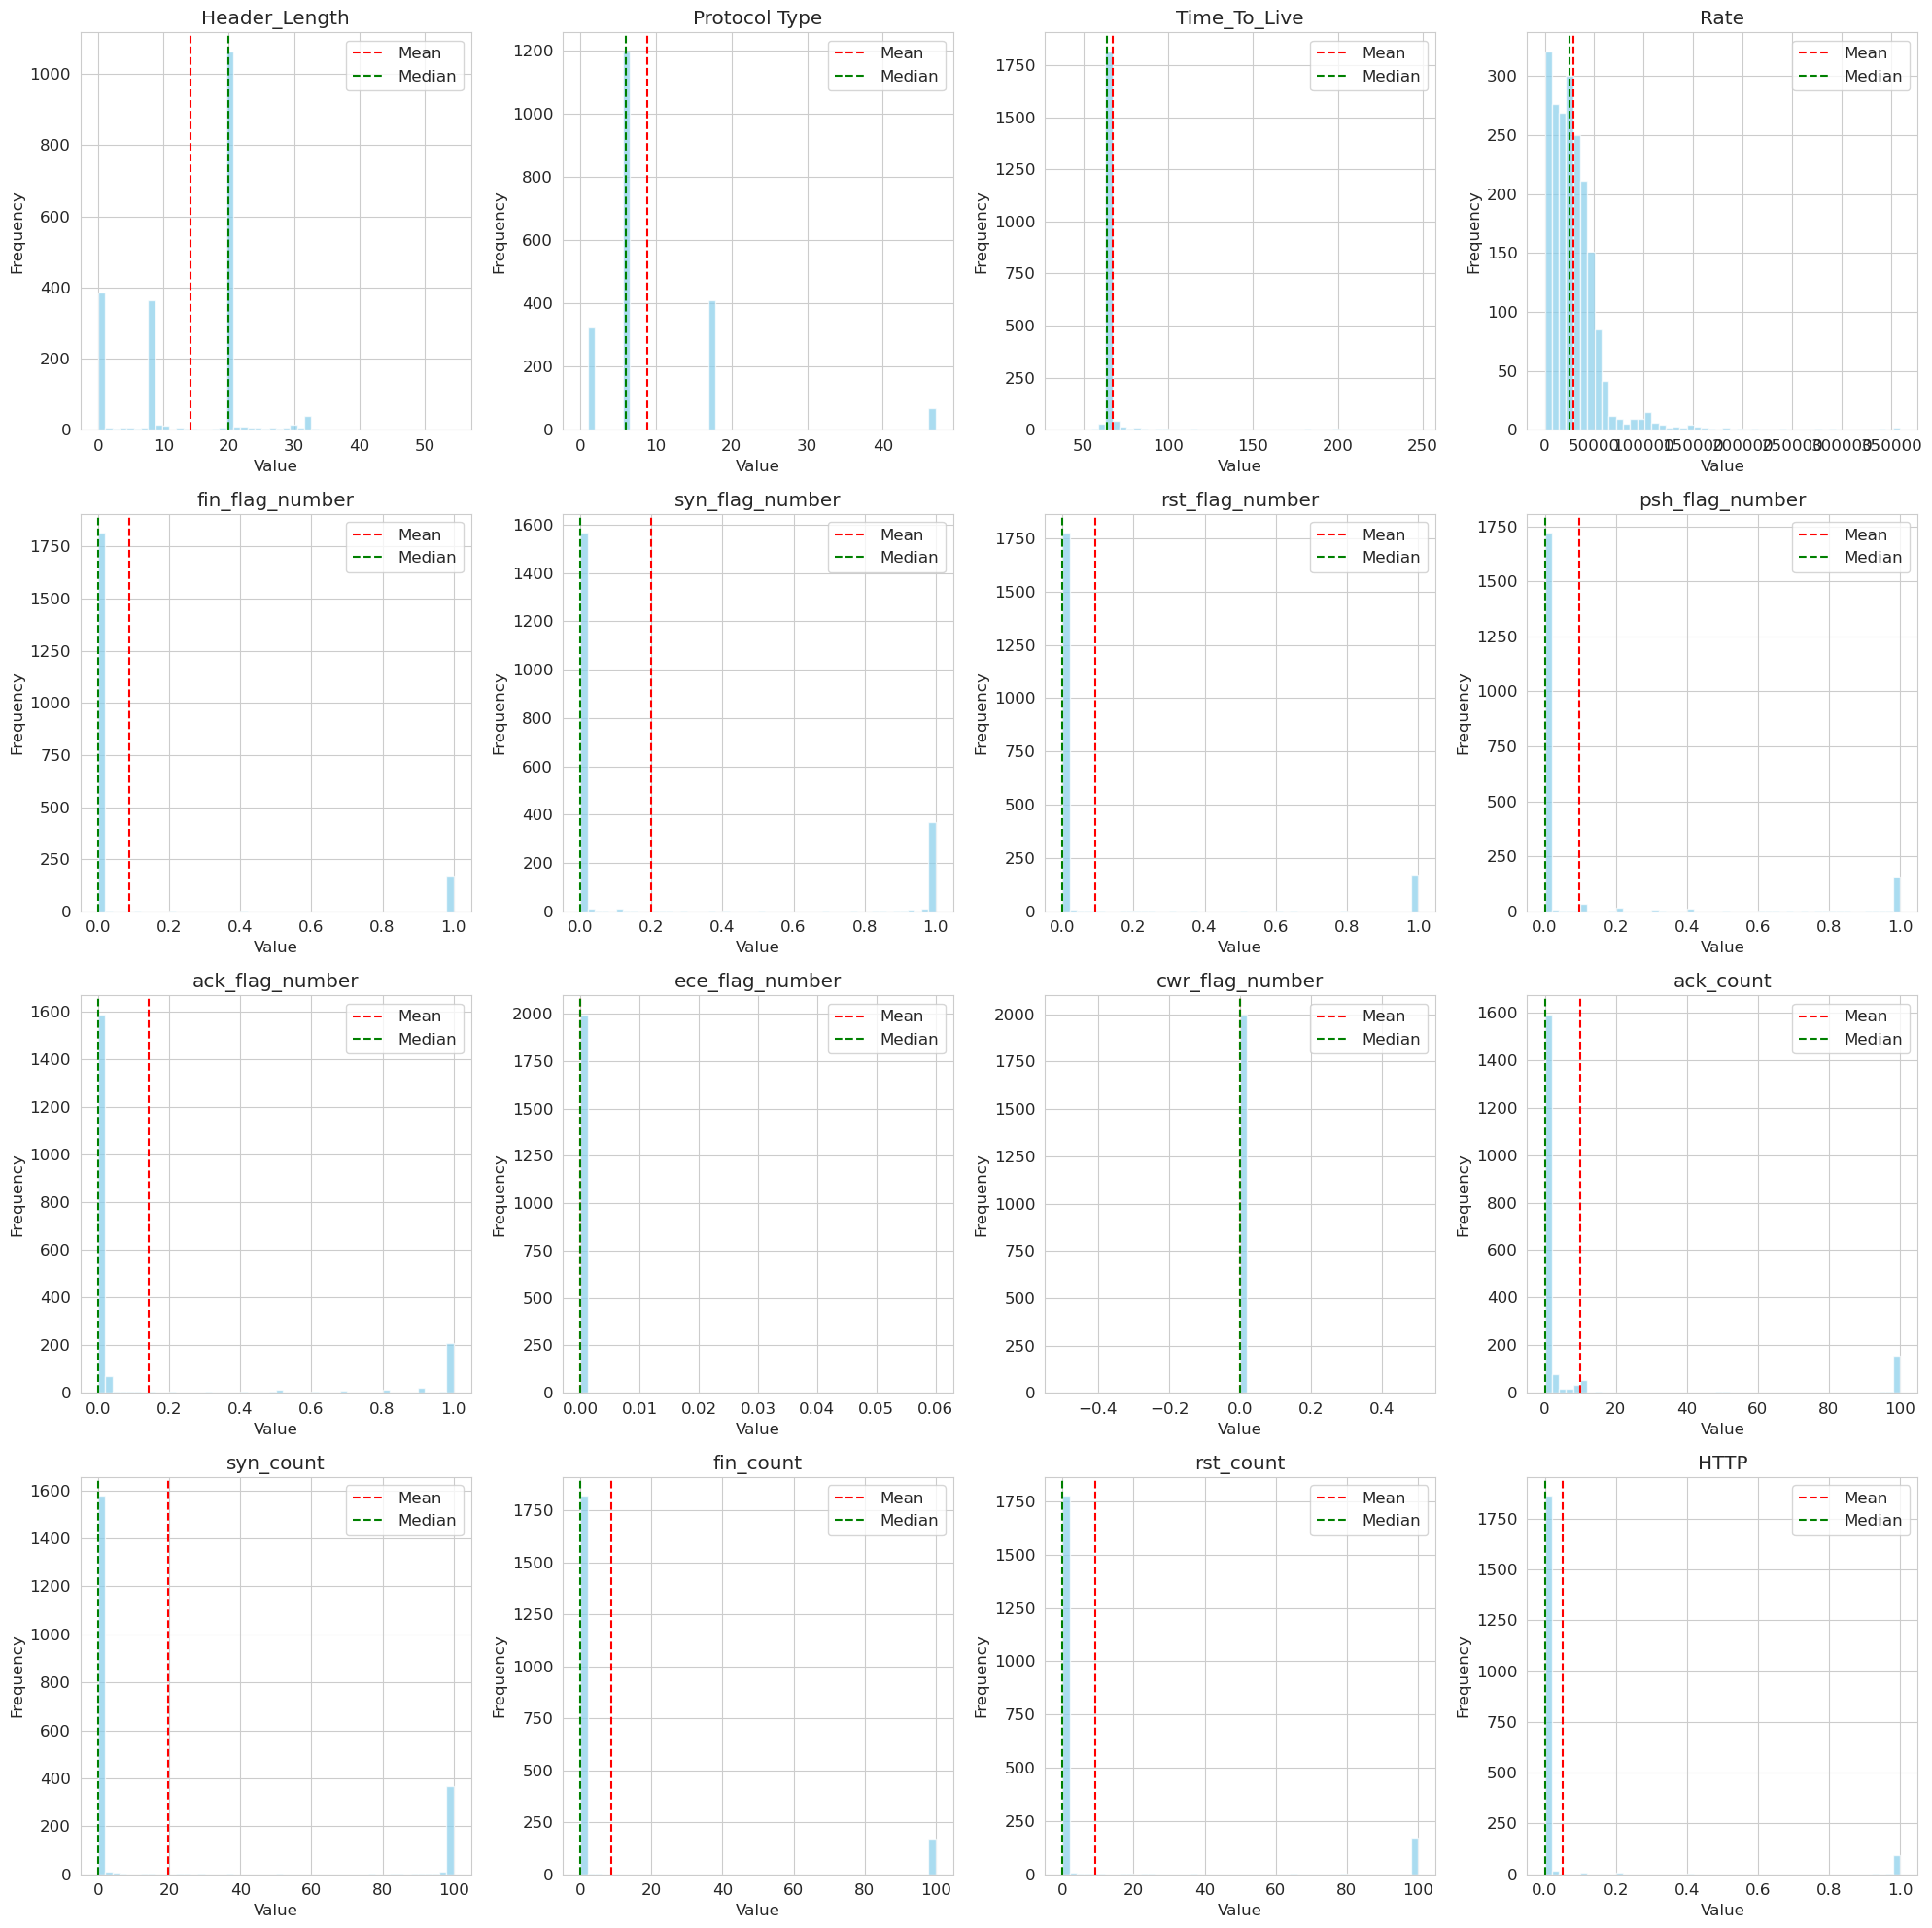

In [12]:
statistical_analysis = comphehensive_statistical_analysis(df)

### Bivariate analysis


In [13]:
def correlation_analysis(df):
    """
    Correlation analysis of the dataset.
    """
    print("="*50)
    print("Correlation analysis of the dataset.")
    print("="*50)

    #Select numeric features
    numeric_features = df.select_dtypes(include=['number']).columns.tolist()

    if 'ts' in numeric_features:
        numeric_features.remove('ts')

    #Compute correlation matrix
    correlation_matrix = df[numeric_features].corr()

    #Plot correlation matrix
    plt.figure(figsize=(20, 16))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.5)
    plt.title('Correlation Matrix - Features CICIoT2023')
    plt.tight_layout()
    plt.show()

    #Identify highly correlated features
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append({
                    'Feature1': correlation_matrix.columns[i], 
                    'Feature2': correlation_matrix.columns[j], 
                    'Correlation': corr_val
                })

    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values(by='Correlation', key=abs, ascending=False)

    print(f"\nHigh correlation pairs (|corr| > 0.7):")
    print(high_corr_df)

    #Save high correlation pairs to csv
    correlation_matrix.to_csv('results/tables/correlation_matrix.csv')
    high_corr_df.to_csv('results/tables/high_corr_pairs.csv', index=False)

    return correlation_matrix, high_corr_df
    

Correlation analysis of the dataset.


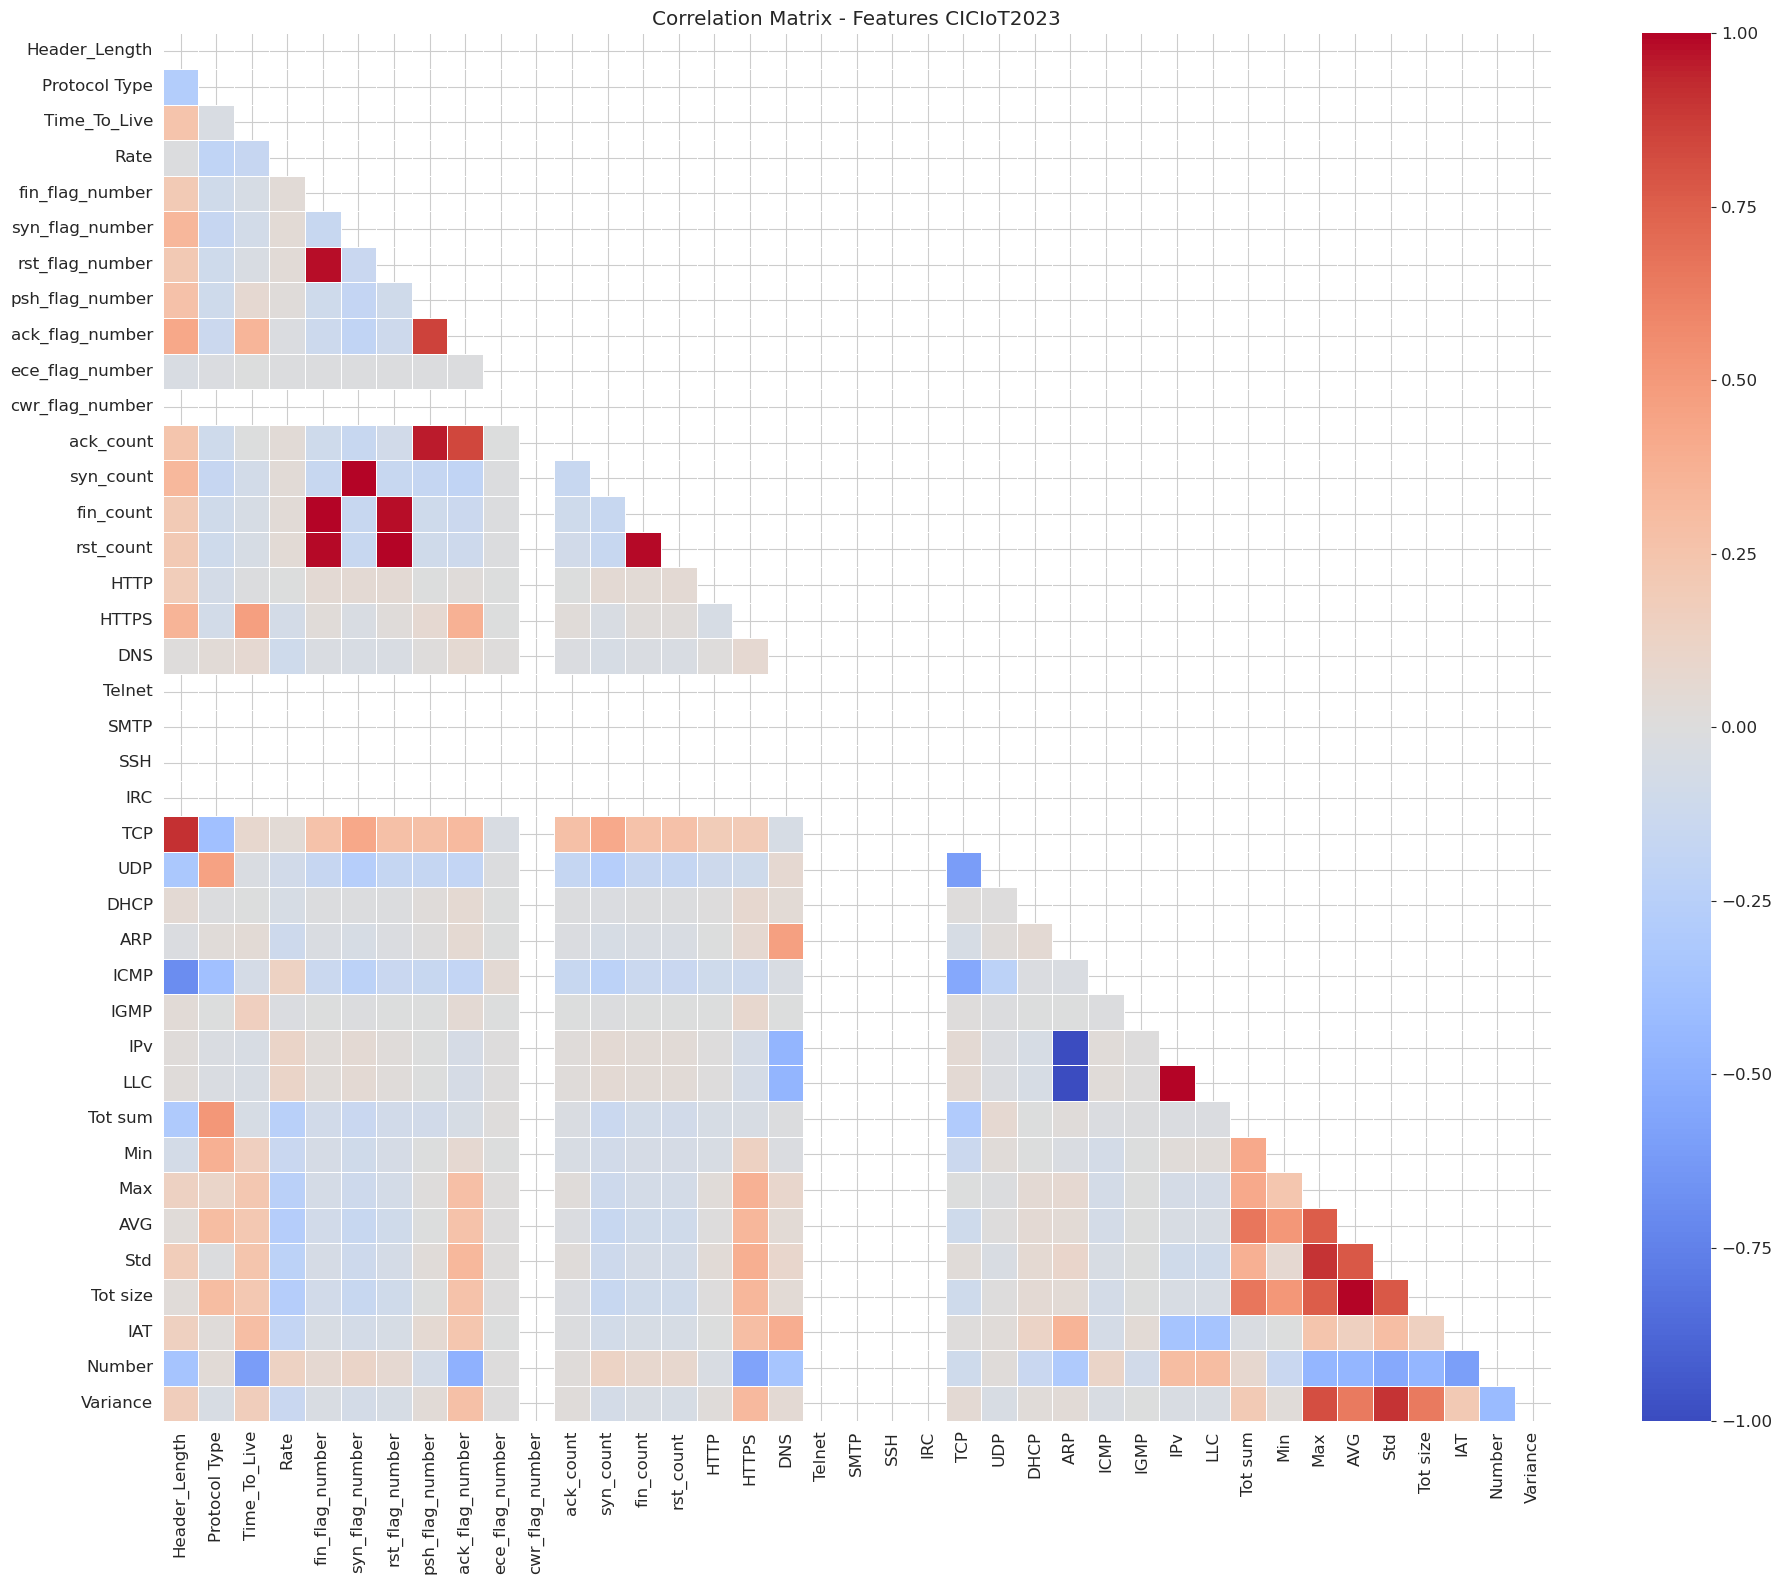


High correlation pairs (|corr| > 0.7):
           Feature1         Feature2  Correlation
19              AVG         Tot size     1.000000
13              IPv              LLC     1.000000
11              ARP              IPv    -1.000000
12              ARP              LLC    -1.000000
2   fin_flag_number        fin_count     0.998861
4   syn_flag_number        syn_count     0.998110
6   rst_flag_number        rst_count     0.996269
10        fin_count        rst_count     0.986666
3   fin_flag_number        rst_count     0.985259
5   rst_flag_number        fin_count     0.982226
1   fin_flag_number  rst_flag_number     0.980968
8   psh_flag_number        ack_count     0.958246
0     Header_Length              TCP     0.913427
15              Max              Std     0.900053
21              Std         Variance     0.899185
7   psh_flag_number  ack_flag_number     0.855767
9   ack_flag_number        ack_count     0.838802
17              Max         Variance     0.818714
18        

In [14]:
corr_matrix, high_corr_df = correlation_analysis(df)

### Analysis by class

In [15]:
def attack_class_analysis(df, label_col='Label'):
    """Analyse features by attack class"""
    print("=" * 50)
    print("Attack Class Analysis")
    print("=" * 50)
    
    # Selecionar features numéricas importantes
    important_features = ['Rate', 'AVG', 'Min', 'Max', 'Std', 'Tot size']
    
    # Estatísticas por classe
    class_stats = df.groupby(label_col)[important_features].agg(['mean', 'std', 'median']).round(4)
    
    # Visualizações comparativas
    n_features = len(important_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
    axes = axes.flatten()
    
    for i, feature in enumerate(important_features):
        df.boxplot(column=feature, by=label_col, ax=axes[i])
        axes[i].set_title(f'{feature} by Attack Class')
        axes[i].set_xlabel('Attack Class')
        axes[i].set_ylabel(feature)
        axes[i].tick_params(axis='x', rotation=90)
    
    # Remover subplots extras
    for i in range(n_features, len(axes)):
        axes[i].remove()

    plt.tight_layout()
    plt.show()

    #ANOVA test for significant differences
    from scipy.stats import f_oneway

    anova_results = []

    classes = df[label_col].unique()

    for feature in important_features:
        groups = [df[df[label_col] == cls][feature].dropna() for cls in classes]
        f_stat, p_value = f_oneway(*groups)
        anova_results.append({
            'Feature': feature,
            'F-statistic': f_stat,
            'p-value': p_value,
            'Significant': p_value < 0.05
        })

    anova_df = pd.DataFrame(anova_results)

    print("\nANOVA Results:")
    print(anova_df)
    

    #Save results
    class_stats.to_csv('results/tables/class_stats.csv')
    anova_df.to_csv('results/tables/anova_results.csv')

    return class_stats, anova_results

Attack Class Analysis


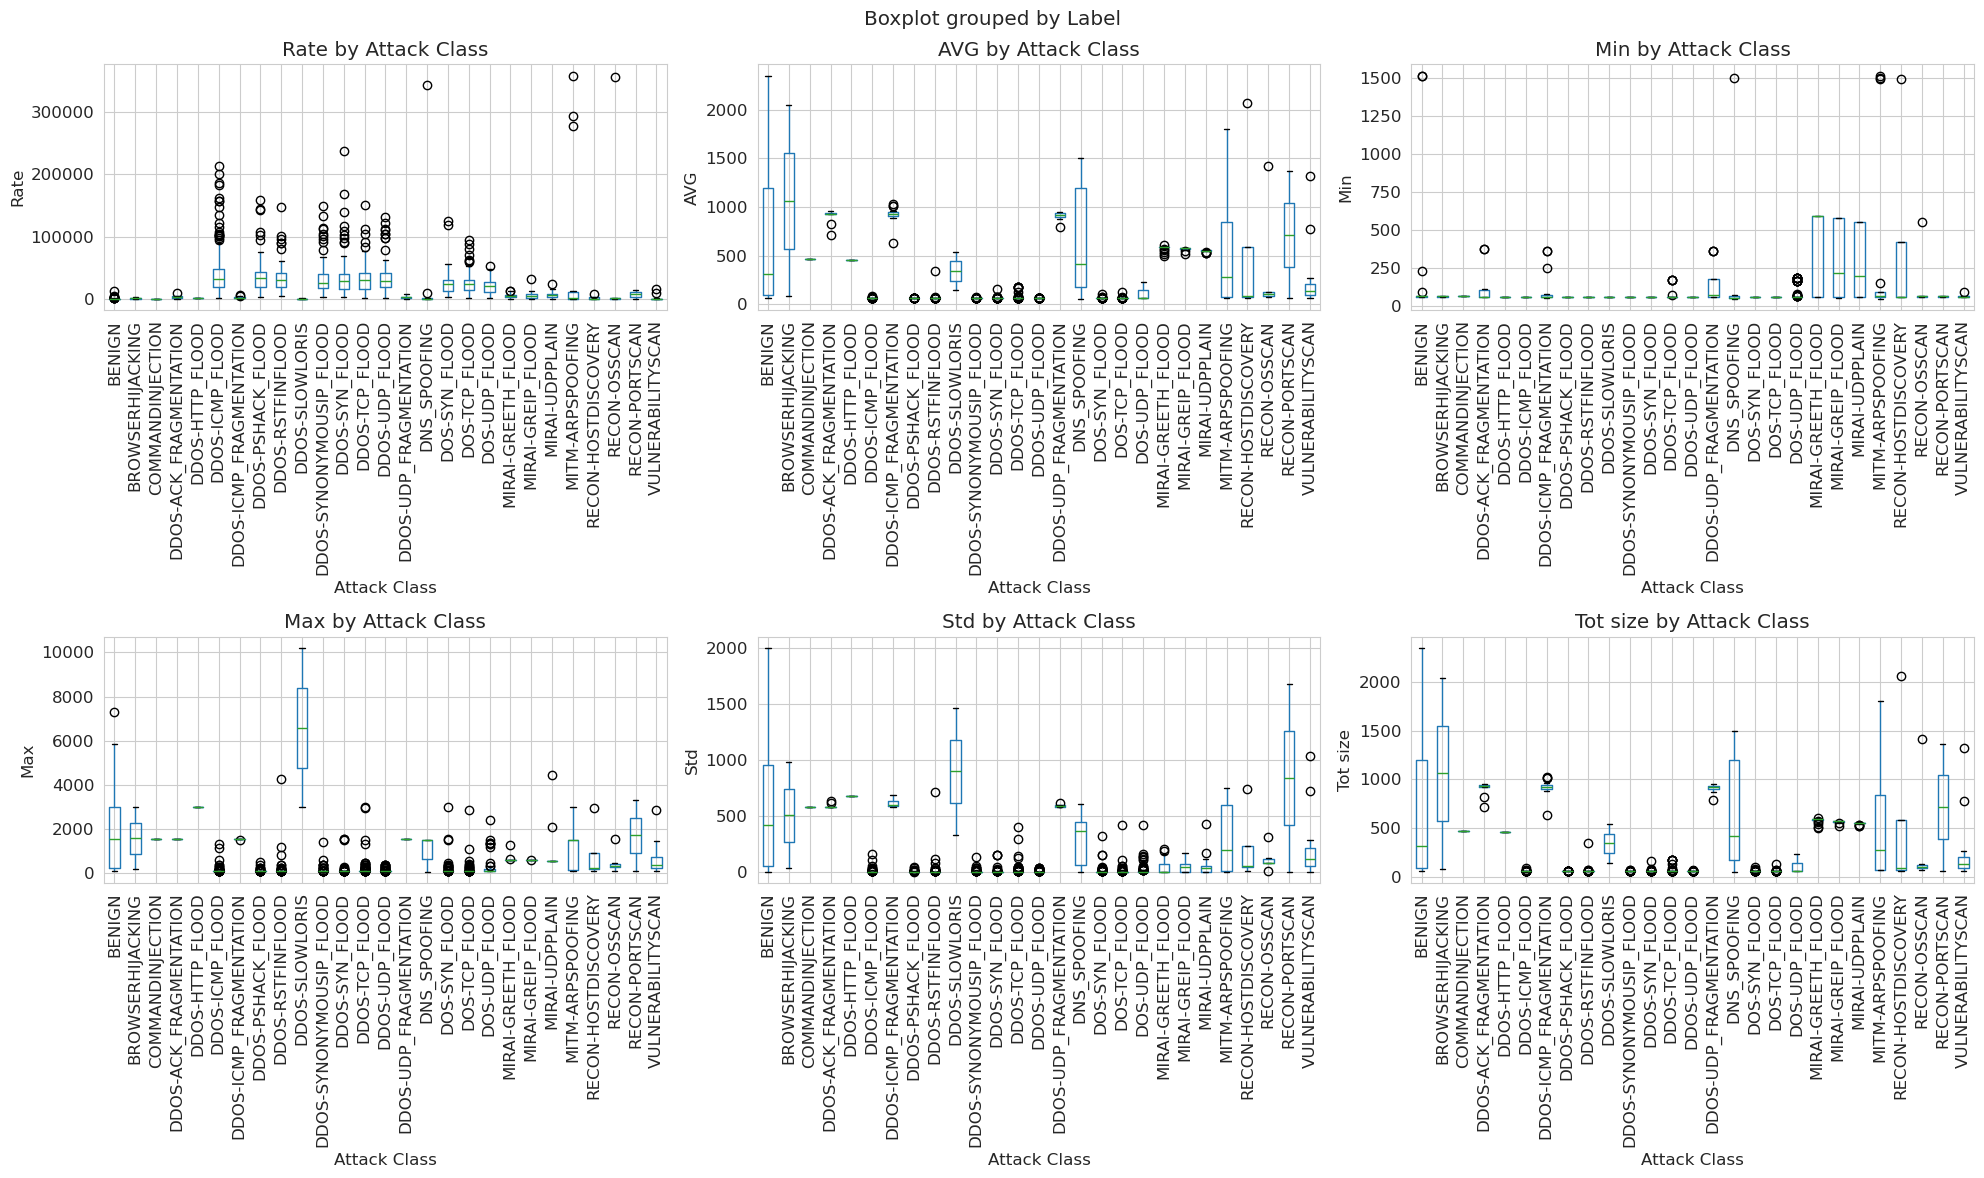


ANOVA Results:
    Feature  F-statistic        p-value  Significant
0      Rate    13.225900   3.458661e-52         True
1       AVG   130.942785   0.000000e+00         True
2       Min    34.692941  8.866748e-141         True
3       Max    80.418124  1.771314e-286         True
4       Std   107.790091   0.000000e+00         True
5  Tot size   130.942785   0.000000e+00         True


In [16]:
class_stats, anova_results = attack_class_analysis(df)